In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import seaborn

seaborn.set()

## INFO
Tento výpočet je proveden s novějšími daty, které končí 13/5/2020, jinak je tento soubor identický jako vypocty_diplomova_prace_calendar_gbm.

# Calendar spread opce simulační výpočet

### Příprava dat

In [2]:
raw_data1 = pd.read_csv("datasets/CLN20.NYM_newer.csv", delimiter=";")
raw_data2 = pd.read_csv("datasets/CLQ20.NYM_newer.csv", delimiter=";")
raw_data1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
646,2020-05-08,25.340000,26.290001,24.820000,26.040001,26.040001,150406692.0
647,2020-05-10,25.910000,26.150000,25.540001,26.020000,26.020000,470755.0
648,2020-05-11,25.780001,26.730000,24.790001,25.430000,25.430000,166885628.0
649,2020-05-12,25.260000,26.860001,25.150000,25.719999,25.719999,162646533.0
650,2020-05-13,26.040001,26.590000,25.530001,26.410000,26.410000,22661319.0


In [3]:
# set date as index for this time series
raw_data1 = raw_data1.set_index("Date")
raw_data2 = raw_data2.set_index("Date")

raw_data1 = raw_data1.iloc[:,3]
raw_data2 = raw_data2.iloc[:,3]
raw_data1.tail()

Date
2020-05-08    26.040001
2020-05-10    26.020000
2020-05-11    25.430000
2020-05-12    25.719999
2020-05-13    26.410000
Name: Close, dtype: float64

For nearest 1 month calendar spread, contract 1 and contract 2 has to be used. For May 2020, the option expiration is 20 April 2020 (day before the nearest of the two futures contracts expires), current calendar is available [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_product_calendar_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).  
The value of a calendar spread is for call (FC1-FC2-S)*1000 or 0 if it is negative. FC1 and FC2 are settlement prices when the option expires.

In [4]:
#selected = raw_data.loc["2015-01-01":, raw_data.columns[0]:raw_data.columns[1]].copy()
selected = pd.DataFrame({"Jul 20":raw_data1,"Aug 20":raw_data2})
selected.index = pd.to_datetime(selected.index)
selected = selected.asfreq(BDay())
selected = selected.fillna(method='ffill').dropna()
selected.tail()

,Jul 20,Aug 20
2020-05-07,24.920000,26.510000
2020-05-08,26.040001,27.900000
2020-05-11,25.430000,27.049999
2020-05-12,25.719999,26.820000
2020-05-13,26.410000,27.080000


In [5]:
selected = selected["2019-07-29":]

### Grafy průběhů obou kontraktů

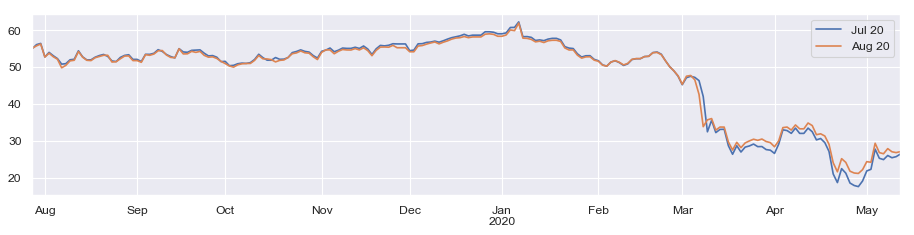

In [6]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in selected.columns:
    selected[col].plot(legend=True)
plt.show()

In [7]:
selected.head()

,Jul 20,Aug 20
2019-07-29,55.009998,55.130001
2019-07-30,56.099998,55.770000
2019-07-31,56.430000,56.270000
2019-08-01,52.770000,52.730000
2019-08-02,54.000000,53.770000


In [8]:
#logs = np.log(selected/selected.shift(1))
change = selected.pct_change()
#logs = logs.dropna()
change = change.dropna()

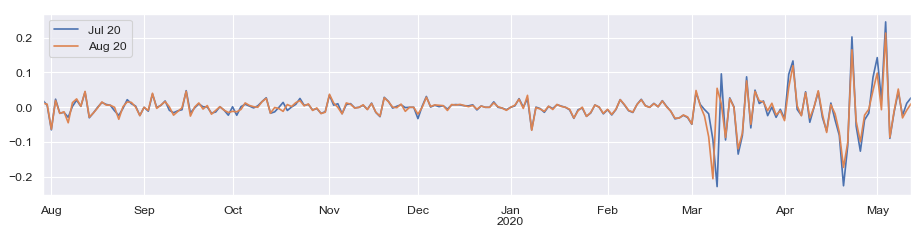

In [9]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in change.columns:
    change[col].plot(legend=True)
plt.show()

### Korelace

Korelace s celým datasetem a bez období skokové změny ceny na nižší hodnotu

When using two different products, it is necessary to include their correlation into simulation, so that the simulated prices move like in real life. Since both timeseries are futures on the same commodity and the only difference is their settlement date, the correlation is very close to 1. (following three lines of code show how to compute correlation in python using numpy)

In [10]:
corres1 = np.corrcoef(change[change.columns[0]],change[change.columns[1]])
cor1 = corres1[1,0]
cor1

0.8476891761159644

In [11]:
print(change.index.min())
print(change.index.max())

2019-07-30 00:00:00
2020-05-13 00:00:00


In [12]:
data3 = change[:"2020-03-05"] 
cor3 = np.corrcoef(data3[data3.columns[0]],data3[data3.columns[1]])
cor3 = cor3[1,0]
cor3


0.9584408057671194

In [13]:
print(data3.index.min())
print(data3.index.max())

2019-07-30 00:00:00
2020-03-05 00:00:00


In [14]:
import scipy.stats as sps


## Calendar spread simulation

Function simulates paths with a GBM model. Random noise is generated from normal distribution, the time gap is assumed to be 1 day, so delta t is 1.

### Find number of steps until expiration

In [15]:
from auxiliary.ContractCalendar import ContractCalendar

calendar_option_contract = ContractCalendar.wti_1m_spread_option()
calendar_option_contract.calendar.head()

,Contract Month,Product Code,First Trade,Last Trade,Settlement
0,June 2020 Crude Oil Financial Calendar Spread ...,7AM20,2015-05-19,2020-05-18,2020-05-18
1,July 2020 Crude Oil Financial Calendar Spread ...,7AN20,2015-06-23,2020-06-19,2020-06-19
2,August 2020 Crude Oil Financial Calendar Sprea...,7AQ20,2015-07-21,2020-07-20,2020-07-20
3,September 2020 Crude Oil Financial Calendar Sp...,7AU20,2015-08-20,2020-08-19,2020-08-19
4,October 2020 Crude Oil Financial Calendar Spre...,7AV20,2015-09-22,2020-09-21,2020-09-21


In [16]:
option_expiration = calendar_option_contract.calendar[calendar_option_contract.calendar["Product Code"]=="7AN20"].iloc[0,-1]
option_expiration

Timestamp('2020-06-19 00:00:00')

In [17]:
all_days = ContractCalendar.get_business_days(start=selected.index[-1], end=option_expiration)
len(all_days)

28

In [18]:
no_of_steps = len(all_days) - 1 # I have to subtract 1 because the initial value is the first day
no_of_steps

27

### Estimate the discount rate

One part of an option's price is it's time value. After performing a simulation to estimate the option's final value, it is necessary to transform that value into a present one. That is done by discounting the value at expiration by a risk free rate. There are multiple possibilites from which risk free rate can be chosen:
 * Domestic risk free rates (Treasury bills, bonds or notes) [Risk free rates in wacc calculation](http://www.eru.cz/documents/10540/5475589/Navrh-zasad-cenove-regulace-2021-2025-pro-verejnou-konzultaci.pdf/f6df3fd5-d5af-425f-a53f-ecbddd4447fe)
 * Interest rates (LIBOR, PRIBOR)
 
Considering the Czech Republic, PRIBOR seems like the best best choice since it is regularly [updated](https://www.cnb.cz/en/financial-markets/money-market/pribor/fixing-of-interest-rates-on-interbank-deposits-pribor/) and offers several term options (1 month up to 1 year) to choose from, which is convenient for option pricing (unless it's an option that expires in a distant future, in that case bonds would be more suitable). [Emission of treasury bills](https://www.mfcr.cz/cs/verejny-sektor/rizeni-statniho-dluhu/emise-statnich-dluhopisu/emisni-kalendare-spp/2020/emisni-kalendar-statnich-pokladnicnich-p-37569) is less frequent with lower selection of due dates.  
<br>
In the following simulation, 1 month PRIBOR rate (1.04%) is used for `discount_rate`. Since the function expects year value, I will multiply the PRIBOR 1 month rate by 12, this is offseted by using 1/12 for the `maturity` parameter.

### Simulation

1 month calendar spread put option, strike is set to 0.1 dollars per barrel, maturity is in one month.

### Výběr hodnot, ze kterých se získají parametry pro model

In [19]:
from auxiliary.distribution_fit import distribution_fit
history_size = 20

change_sliced = change.iloc[-history_size:,:]

In [20]:
std_change = change_sliced.std()
std_change

Jul 20    0.110624
Aug 20    0.089888
dtype: float64

In [21]:
mean_change = change_sliced.mean()
mean_change

Jul 20   -0.001072
Aug 20   -0.004069
dtype: float64

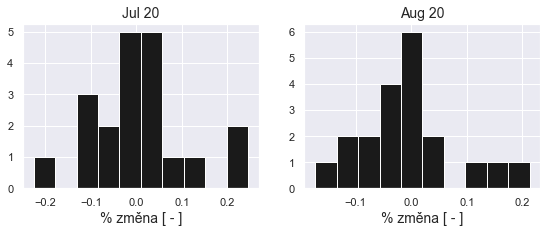

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
ax1.hist(change_sliced["Jul 20"], color="k", bins=10)
ax1.set_title("Jul 20", fontsize=14)
ax1.set_xlabel("% změna [ - ]",fontsize=14)
ax2.hist(change_sliced["Aug 20"], color="k", bins=10)
ax2.set_title("Aug 20",fontsize=14)
ax2.set_xlabel("% změna [ - ]",fontsize=14)
fig.savefig('calendar_hist.pdf', format='pdf', bbox_inches='tight')

In [23]:
from statsmodels.stats.stattools import jarque_bera
j1 = jarque_bera(change_sliced["Jul 20"])
j2 = jarque_bera(change_sliced["Aug 20"])
print(j1)
print(j2)
pd.DataFrame({"Jul 20":j1,"Aug 20":j2}, index=["JB hodnota","p hodnota", "šikmost", "špičatost"])

(0.7335727638861582, 0.6929576575030862, 0.4438778785643078, 3.303606706692043)
(1.776100263289681, 0.4114572585709747, 0.6684507393104641, 3.5865277081338895)


,Jul 20,Aug 20
JB hodnota,0.733573,1.776100
p hodnota,0.692958,0.411457
šikmost,0.443878,0.668451
špičatost,3.303607,3.586528


 Korelace 

In [24]:
corres1 = np.corrcoef(change_sliced[change_sliced.columns[0]],change_sliced[change_sliced.columns[1]])
cor1 = corres1[1,0]
cor1

0.9905021409352541

In [25]:
print(change_sliced.index.max())
print(change_sliced.index.min())

2020-05-13 00:00:00
2020-04-16 00:00:00


### Simulační výpočet
Funkce simulace spread_simulation_gbm_final je ve složce simulations v souboru simulations.py

In [26]:
from simulations.simulations import spread_simulation_gbm_final
position_flag = "p"
initial_price1 = selected.iloc[-1,0]
initial_price2 = selected.iloc[-1,1]
strike = -3
sim = 10000
steps = no_of_steps
loc1 = mean_change[0]
loc2 = mean_change[1]
scale1 = std_change[0]
scale2 = std_change[1]
cor = cor1

np.random.seed(19121995)

total, paths, payoffs = spread_simulation_gbm_final(
                                     position_flag=position_flag,
                                     initial_price1=initial_price1,
                                     initial_price2=initial_price2,
                                     strike=strike,
                                     simulations=sim,
                                     steps=steps,
                                     loc1=loc1,
                                     loc2=loc2,
                                     scale1=scale1,
                                     scale2=scale2,
                                     cor=cor,
                                     )

Výpočet diskontované ceny

In [27]:
discount_rate = 0.01 # chosen discount rate
maturity = no_of_steps/252 

In [28]:
(np.exp(-discount_rate*maturity)/sim)*total

0.012751559148380791

Ze [stránek CME](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_quotes_settlements_options.html?optionProductId=2952&optionExpiration=2952-M0#optionProductId=2952&optionExpiration=2952-N0&tradeDate=05%2F13%2F2020) zmizel strike na -$3 na PUT na tuto opci, teď tam je pouze -3.5 (cena 13/5  0.23) a -2.5 (cena 13/5  0.32).  

Simulační výpočet je mnohem blíže cenám na stránkách burzy než při dřívějším výpočtu (0.6 dolaru ze simulačního výpočtu oproti 3.09 dolarům ceny na stránkách burzy).

#### Graf s první ukázkovu simulací

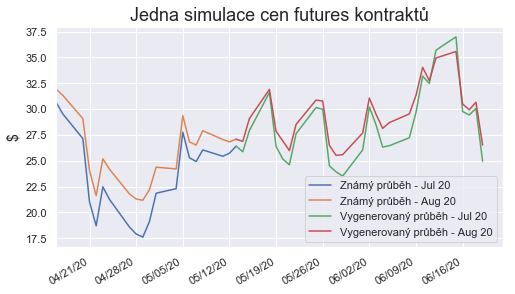

In [29]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4.5))
ax.set_title("Jedna simulace cen futures kontraktů", fontsize=18)
ax.plot(selected.iloc[-20:,0], label="Známý průběh - Jul 20")
ax.plot(selected.iloc[-20:,1], label="Známý průběh - Aug 20")
for path in paths[0][0:1]:
    ax.plot(all_days, path, label="Vygenerovaný průběh - Jul 20")
for path in paths[1][0:1]:
    ax.plot(all_days, path, label="Vygenerovaný průběh - Aug 20")
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(selected.index[-20], all_days[-1]+BDay())
fig.autofmt_xdate()
ax.legend()
plt.show()
fig.savefig('sim_calendar.pdf', format='pdf', bbox_inches='tight')

Parametry pro funkci pro kontrolní výpočet

In [30]:
params = pd.DataFrame(
                        {"Params":[initial_price1, initial_price2, strike, maturity, discount_rate * 100, scale1 * np.sqrt(252) * 100, scale2 * np.sqrt(252) * 100, cor]},
                        index=["S1","S2","X","Maturity","r","sigma1","sigma2","cor"]
                        )
params

,Params
S1,26.410000
S2,27.080000
X,-3.000000
Maturity,0.107143
r,1.000000
sigma1,175.609550
sigma2,142.693104
cor,0.990502


The contract is more closely described [here](https://www.cmegroup.com/content/dam/cmegroup/rulebook/NYMEX/3/397.pdf) and current info about price and volumes are [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_contractSpecs_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).

Vykreslení grafu prvních 100 simulací

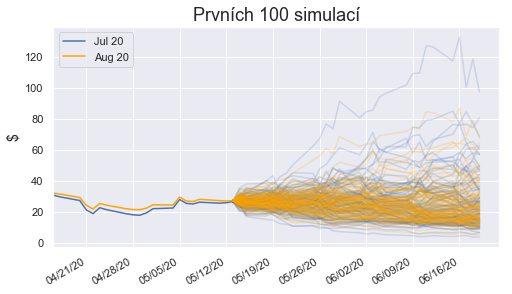

In [31]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4.5))
ax.set_title("Prvních 100 simulací", fontsize=18)
ax.plot(selected.iloc[-20:,0],c="b")
ax.plot(selected.iloc[-20:,1],c="orange")
for path in paths[0][0:100]:
    ax.plot(all_days, path, c="b", alpha=0.2)
for path in paths[1][0:100]:
    ax.plot(all_days, path, c="orange", alpha=0.2)
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(selected.index[-20], all_days[-1]+BDay())
fig.autofmt_xdate()
ax.legend()
plt.show()
fig.savefig('sim_calendar_100.pdf', format='pdf', bbox_inches='tight')

Výpočet konfidenčního intervalu

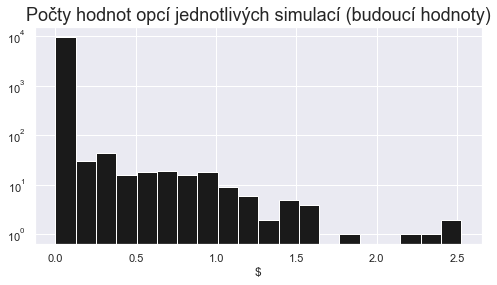

In [32]:
s = pd.Series(payoffs)
s[s>0]
plt.figure(figsize=(8, 4))
plt.title("Počty hodnot opcí jednotlivých simulací (budoucí hodnoty)", fontsize=18)
plt.xlabel("$")
plt.yscale('log', nonposy='clip')
plt.hist(s, bins=20, color="k")
plt.plot()
plt.savefig('sim_calendar_payoffs.pdf', format='pdf', bbox_inches='tight')

In [33]:
s.std()

0.10833575444925084

In [34]:
se = s.std()/np.sqrt(sim)
se

0.0010833575444925084